# 3 - Modelado Predictivo

**Objetivo**

Análisis de la caída en ventas de la *Línea Joven* (18-25 años) y construir modelos de Aprendizaje Automático para identificar factores que afectan a la conversión y las ventas, generando recomendaciones.

## 1 Cargas de Librerías

In [36]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Configuración General
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10, 6)

# Directorios
data_dir = "../data/processed"
fig_dir = "../reports/figures/modeling"
os.makedirs(fig_dir, exist_ok=True)


## 2 Carga de los Datasets Procesado

In [37]:
clientes = pd.read_csv(os.path.join(data_dir, "clientes_feature_engineered.csv"))
marketing = pd.read_csv(os.path.join(data_dir, "marketing_feature_engineered.csv"))
ventas = pd.read_csv(os.path.join(data_dir, "ventas_feature_engineered.csv"))
web_data = pd.read_csv(os.path.join(data_dir, "web_data_feature_engineered.csv"))

# Primer Vistazo
print(clientes.head())
print(marketing.head())
print(ventas.head())
print(web_data.head())


   cliente_id  edad región fecha_encuesta        linea_usada  satisfaccion  \
0       10000    27  Oeste     2025-04-14     linea_orgánica             2   
1       10001    45  Norte     2025-03-04  linea_profesional             4   
2       10002    22   Este     2025-03-12  linea_profesional             4   
3       10003    19  Norte     2025-02-05     linea_orgánica             1   
4       10004    25    Sur     2025-02-17     linea_orgánica             5   

          comentarios  anio_encuesta  mes_encuesta edad_grupo  es_linea_joven  
0      Precio elevado           2025             4      25-34           False  
1      Muy buen aroma           2025             3      35-49           False  
2  Excelente producto           2025             3      18-24           False  
3    No vi resultados           2025             2      18-24           False  
4    No vi resultados           2025             2      25-34           False  
        fecha     canal      campaña linea_asociada

## 3 Filtrado de la *Línea Joven*

Enfoque en clientes de 18 a 25 años, ya que el problema del negocio se centra en esta línea.

In [38]:
# Filtramos clientes entre 18 y 25 años
clientes_joven = clientes[(clientes['edad'] >= 18) & (clientes['edad'] <= 25)]
print(f"Clientes entre 18 y 25 años: {clientes_joven.shape}")

# Filtramos ventas, web y marketing por línea joven
ventas_joven = ventas[ventas['es_linea_joven'] == True]
web_joven = web_data[web_data['es_linea_joven'] == True]
marketing_joven = marketing[marketing['es_linea_joven'] == True]

print(f"Ventas línea joven: {ventas_joven.shape}")
print(f"Web línea joven: {web_joven.shape}")
print(f"Marketing línea joven: {marketing_joven.shape}")

Clientes entre 18 y 25 años: (81, 11)
Ventas línea joven: (348, 16)
Web línea joven: (264, 16)
Marketing línea joven: (150, 13)


## 4. Resumen de Estadísticas Básicas - Línea Joven

Resumen estadístico de Ventas Línea Joven:


,unidades_vendidas,precio_unitario
count,348.000000,348.000000
mean,14.942529,1553.896552
std,8.957931,640.379369
min,1.000000,84.000000
25%,7.000000,1112.750000
50%,15.000000,1637.000000
75%,22.000000,2086.750000
max,30.000000,2496.000000



Resumen estadístico de Web Línea Joven:


,tiempo_en_pagina_s
count,264.000000
mean,89.742424
std,49.121502
min,10.000000
25%,47.750000
50%,87.500000
75%,131.000000
max,180.000000



Resumen estadístico de Marketing Línea Joven:


,inversion_usd
count,150.000000
mean,3234.440000
std,1679.757719
min,503.000000
25%,1701.250000
50%,3495.500000
75%,4724.000000
max,5969.000000


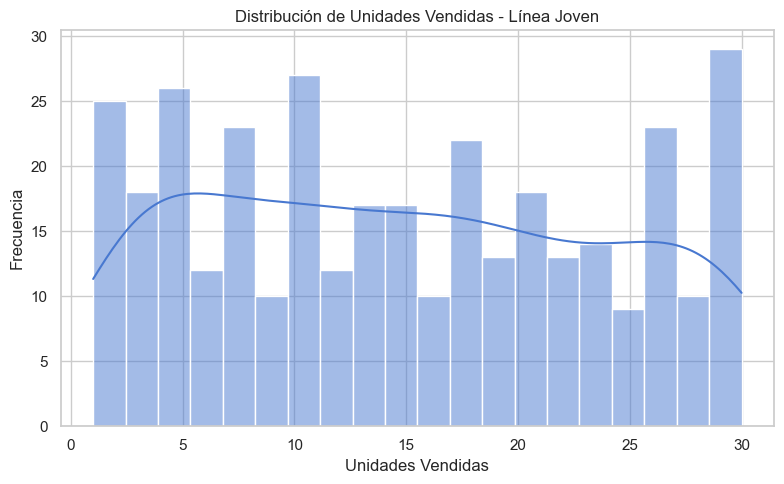

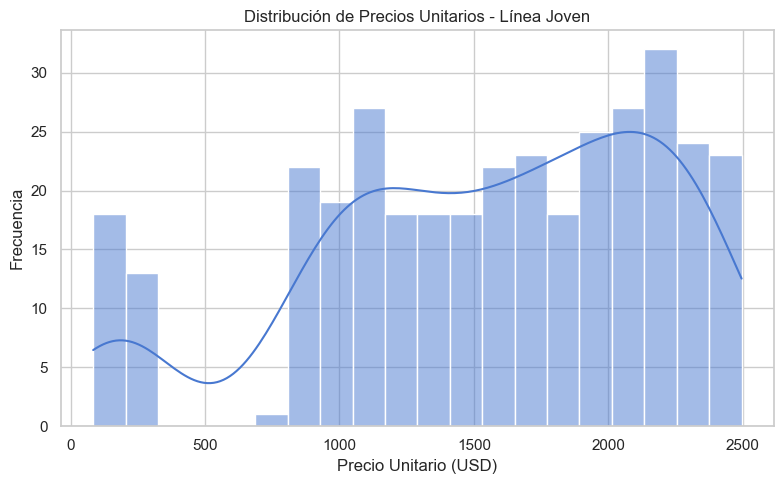

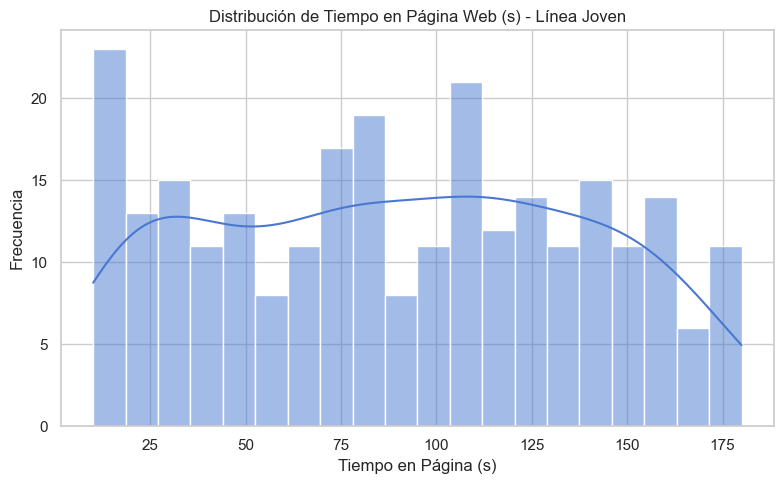

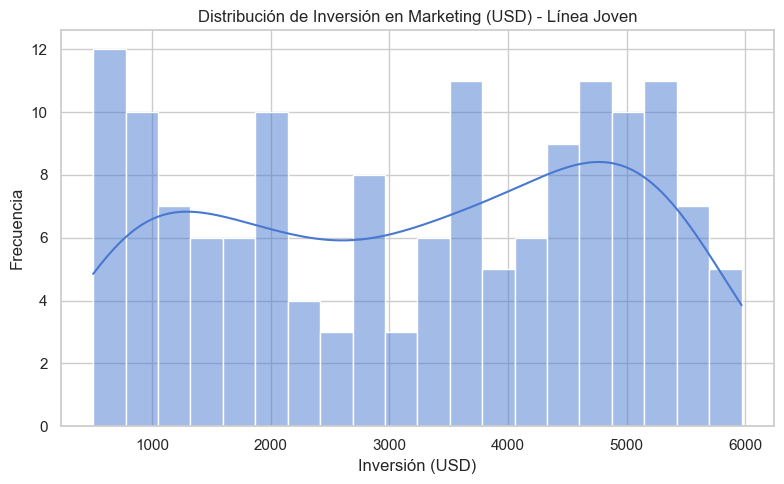

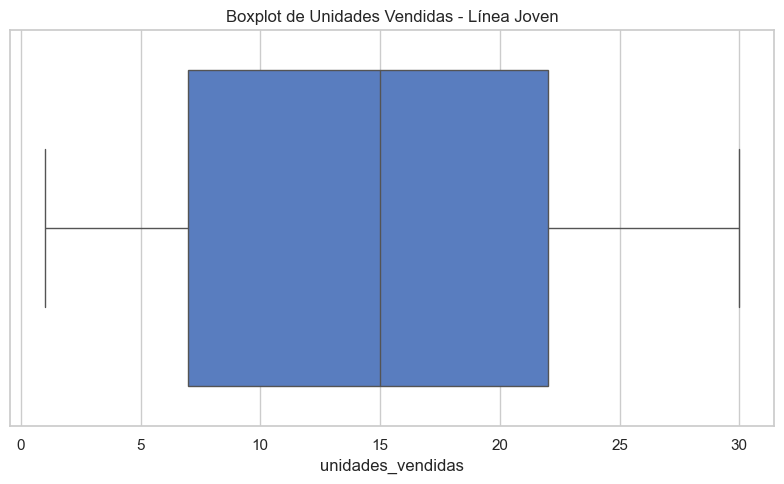

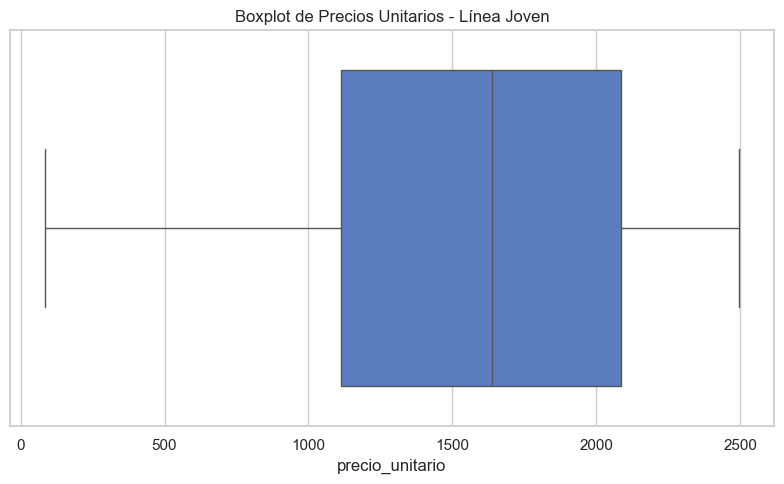

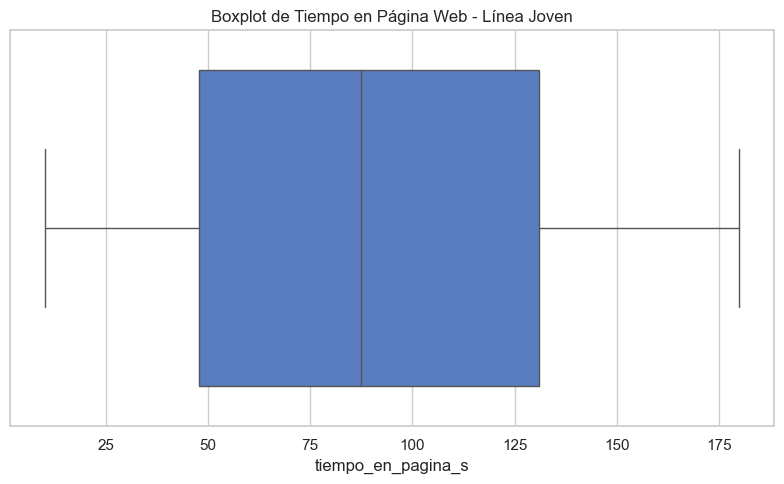

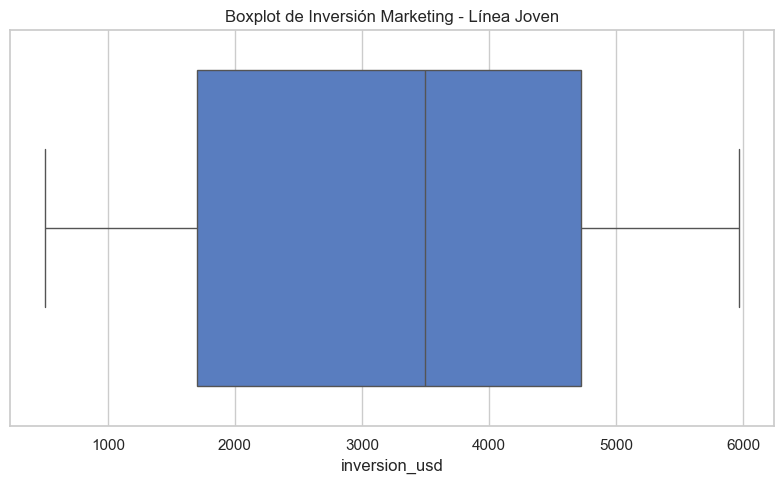

Estadísticas y gráficos básicos generados, mostrados y guardados en subcarpetas de modeling.


In [39]:
# Carpeta base
figures_dir = '../reports/figures/modeling'
os.makedirs(figures_dir, exist_ok=True)

# Función para guardar figuras en subcarpetas según tipo
def guardar_y_mostrar(fig, nombre_archivo, tipo="general"):
    subdir = os.path.join(figures_dir, tipo)
    os.makedirs(subdir, exist_ok=True)
    fig.savefig(os.path.join(subdir, nombre_archivo))
    plt.show()
    plt.close(fig)

# --- Mostrar resumen estadístico en consola ---
print("Resumen estadístico de Ventas Línea Joven:")
display(ventas_joven[['unidades_vendidas','precio_unitario']].describe())
print("\nResumen estadístico de Web Línea Joven:")
display(web_joven[['tiempo_en_pagina_s']].describe())
print("\nResumen estadístico de Marketing Línea Joven:")
display(marketing_joven[['inversion_usd']].describe())

# --- Histogramas ---
hist_data = [
    (ventas_joven['unidades_vendidas'], "Distribución de Unidades Vendidas - Línea Joven", "Unidades Vendidas", "hist_unidades_vendidas.png"),
    (ventas_joven['precio_unitario'], "Distribución de Precios Unitarios - Línea Joven", "Precio Unitario (USD)", "hist_precio_unitario.png"),
    (web_joven['tiempo_en_pagina_s'], "Distribución de Tiempo en Página Web (s) - Línea Joven", "Tiempo en Página (s)", "hist_tiempo_web.png"),
    (marketing_joven['inversion_usd'], "Distribución de Inversión en Marketing (USD) - Línea Joven", "Inversión (USD)", "hist_inversion_marketing.png")
]

for serie, titulo, xlabel, filename in hist_data:
    fig = plt.figure(figsize=(8,5))
    sns.histplot(serie, bins=20, kde=True)
    plt.title(titulo)
    plt.xlabel(xlabel)
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    guardar_y_mostrar(fig, filename, tipo="histograms")

# --- Boxplots ---
box_data = [
    (ventas_joven['unidades_vendidas'], "Boxplot de Unidades Vendidas - Línea Joven", "boxplot_unidades_vendidas.png"),
    (ventas_joven['precio_unitario'], "Boxplot de Precios Unitarios - Línea Joven", "boxplot_precio_unitario.png"),
    (web_joven['tiempo_en_pagina_s'], "Boxplot de Tiempo en Página Web - Línea Joven", "boxplot_tiempo_web.png"),
    (marketing_joven['inversion_usd'], "Boxplot de Inversión Marketing - Línea Joven", "boxplot_inversion_marketing.png")
]

for serie, titulo, filename in box_data:
    fig = plt.figure(figsize=(8,5))
    sns.boxplot(x=serie)
    plt.title(titulo)
    plt.tight_layout()
    guardar_y_mostrar(fig, filename, tipo="boxplots")

print("Estadísticas y gráficos básicos generados, mostrados y guardados en subcarpetas de modeling.")

## 5. Análisis Temporal de la *Línea Joven*

Enfocada en **análisis temporal y tendencias de la Línea Joven**, con salidas en consola, gráficos en notebook y guardado en `reports/figures/modeling`.

Resumen Mensual de Ventas - Línea Joven


,anio_mes,unidades_vendidas,ingresos_totales,precio_promedio
0,2024-05-01,500,609501,1590.937500
1,2024-06-01,377,507629,1502.785714
2,2024-07-01,473,629078,1617.000000
3,2024-08-01,404,529331,1457.200000
4,2024-09-01,403,582933,1622.000000



Resumen Mensual de Web - Línea Joven


,anio_mes,visitas,tiempo_promedio_s,clics_total,add_to_cart_total,compras_total
0,2024-05-01,26,80.269231,10,4,3
1,2024-06-01,18,92.111111,9,3,0
2,2024-07-01,23,105.826087,10,4,2
3,2024-08-01,25,91.240000,6,1,0
4,2024-09-01,18,87.388889,3,1,0



Resumen Mensual de Marketing - Línea Joven


,anio_mes,inversion_total,conversiones_total
0,2024-05-01,30315,736
1,2024-06-01,44270,762
2,2024-07-01,38716,834
3,2024-08-01,49303,989
4,2024-09-01,32231,402


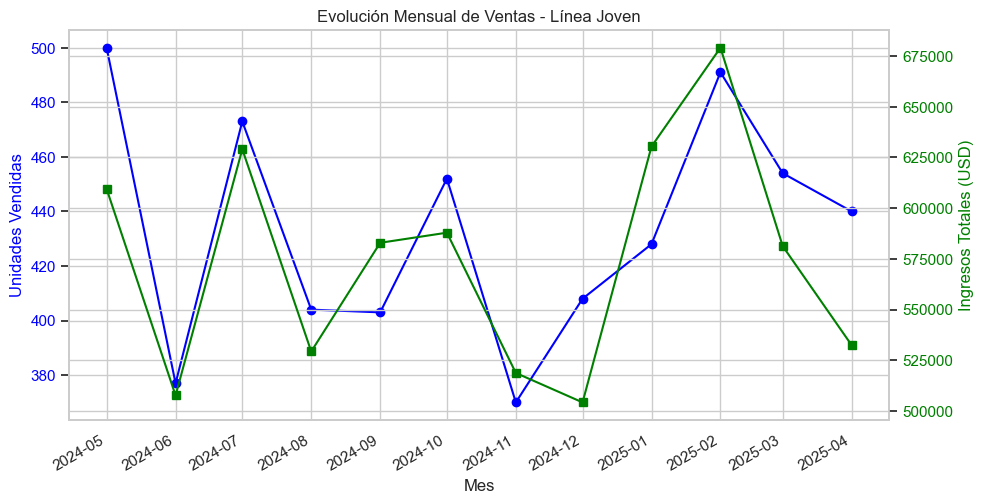

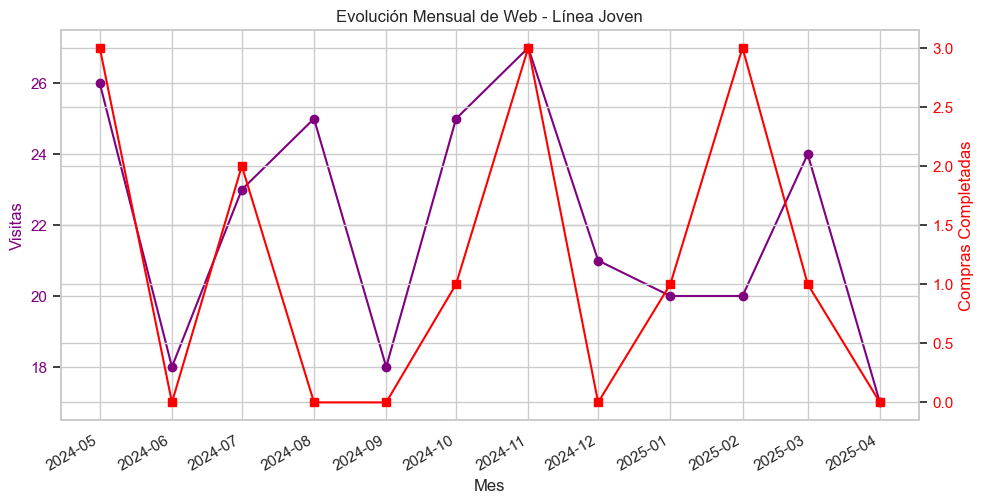

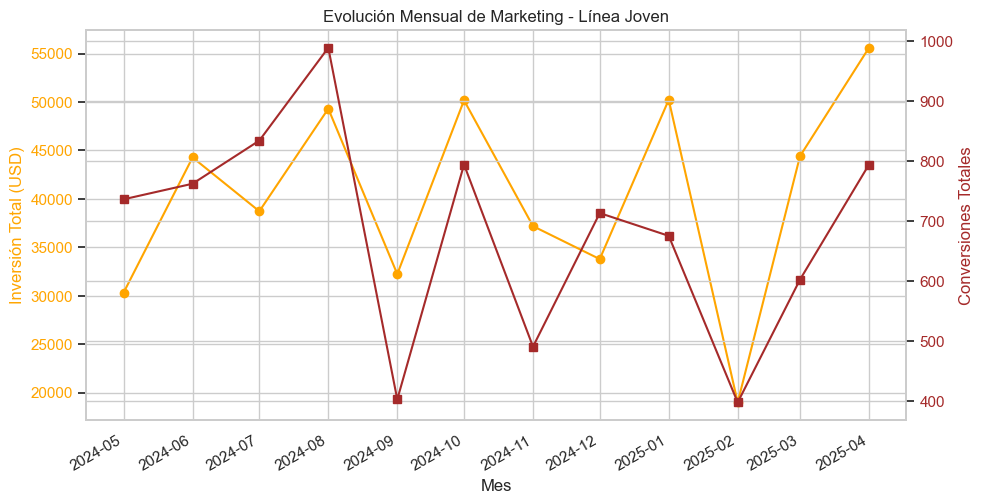

Evolución temporal de ventas, web y marketing generada, mostrada y guardada en subcarpetas de modeling.


In [40]:
# Copias para evitar warnings
ventas_joven = ventas_joven.copy()
web_joven = web_joven.copy()
marketing_joven = marketing_joven.copy()

# Columna anio_mes
for df in [ventas_joven, web_joven, marketing_joven]:
    df['anio_mes'] = pd.to_datetime(dict(year=df['anio'], month=df['mes'], day=1))

# Agregar métricas por mes
ventas_mes = ventas_joven.groupby('anio_mes').agg(
    unidades_vendidas=('unidades_vendidas','sum'),
    ingresos_totales=('total_ingresos','sum'),
    precio_promedio=('precio_unitario','mean')
).reset_index()

web_mes = web_joven.groupby('anio_mes').agg(
    visitas=('fecha','count'),
    tiempo_promedio_s=('tiempo_en_pagina_s','mean'),
    clics_total=('clic_en_producto','sum'),
    add_to_cart_total=('anadir_al_carrito','sum'),
    compras_total=('compra_completada','sum')
).reset_index()

marketing_mes = marketing_joven.groupby('anio_mes').agg(
    inversion_total=('inversion_usd','sum'),
    conversiones_total=('conversiones','sum')
).reset_index()

# --- Mostrar resumen mensual en consola ---
print("Resumen Mensual de Ventas - Línea Joven")
display(ventas_mes.head(5))  # Primera muestra
print("\nResumen Mensual de Web - Línea Joven")
display(web_mes.head(5))
print("\nResumen Mensual de Marketing - Línea Joven")
display(marketing_mes.head(5))

# Función para graficar evolución temporal
def plot_evolucion(df, col1, col2, label1, label2, color1, color2, titulo, nombre_archivo):
    fig, ax1 = plt.subplots(figsize=(10,5))
    ax1.plot(df['anio_mes'], df[col1], marker='o', color=color1, label=label1)
    ax1.set_xlabel("Mes")
    ax1.set_ylabel(label1, color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    ax2 = ax1.twinx()
    ax2.plot(df['anio_mes'], df[col2], marker='s', color=color2, label=label2)
    ax2.set_ylabel(label2, color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.title(titulo)
    
    guardar_y_mostrar(fig, nombre_archivo, tipo="evolucion")

# Graficar evolución
plot_evolucion(ventas_mes, 'unidades_vendidas', 'ingresos_totales',
               'Unidades Vendidas', 'Ingresos Totales (USD)',
               'blue','green', "Evolución Mensual de Ventas - Línea Joven",
               "evolucion_ventas_mes.png")

plot_evolucion(web_mes, 'visitas', 'compras_total',
               'Visitas', 'Compras Completadas',
               'purple','red', "Evolución Mensual de Web - Línea Joven",
               "evolucion_web_mes.png")

plot_evolucion(marketing_mes, 'inversion_total', 'conversiones_total',
               'Inversión Total (USD)', 'Conversiones Totales',
               'orange','brown', "Evolución Mensual de Marketing - Línea Joven",
               "evolucion_marketing_mes.png")

print("Evolución temporal de ventas, web y marketing generada, mostrada y guardada en subcarpetas de modeling.")

## 6. Análisis de Correlaciones y Posibles Factores de Caída

Primeras filas del DataFrame combinado mensual:


,anio_mes,unidades_vendidas,ingresos_totales,precio_promedio,visitas,tiempo_promedio_s,clics_total,add_to_cart_total,compras_total,inversion_total,conversiones_total
0,2024-05-01,500,609501,1590.937500,26,80.269231,10,4,3,30315,736
1,2024-06-01,377,507629,1502.785714,18,92.111111,9,3,0,44270,762
2,2024-07-01,473,629078,1617.000000,23,105.826087,10,4,2,38716,834
3,2024-08-01,404,529331,1457.200000,25,91.240000,6,1,0,49303,989
4,2024-09-01,403,582933,1622.000000,18,87.388889,3,1,0,32231,402



Matriz de correlaciones:


,unidades_vendidas,ingresos_totales,precio_promedio,visitas,tiempo_promedio_s,clics_total,add_to_cart_total,compras_total,inversion_total,conversiones_total
unidades_vendidas,1.000000,0.779463,0.065242,0.145233,-0.120217,0.074358,0.056062,0.501055,-0.309533,0.009196
ingresos_totales,0.779463,1.000000,0.461263,0.012838,0.045610,-0.160045,0.123864,0.558375,-0.414494,-0.330501
precio_promedio,0.065242,0.461263,1.000000,0.137262,-0.022085,-0.024545,0.473100,0.440319,0.065038,-0.234884
visitas,0.145233,0.012838,0.137262,1.000000,0.227356,0.507404,0.336581,0.542531,-0.058068,0.190892
tiempo_promedio_s,-0.120217,0.045610,-0.022085,0.227356,1.000000,0.114313,-0.069224,-0.005993,-0.128279,0.201860
clics_total,0.074358,-0.160045,-0.024545,0.507404,0.114313,1.000000,0.682323,0.468566,-0.036624,0.221263
add_to_cart_total,0.056062,0.123864,0.473100,0.336581,-0.069224,0.682323,1.000000,0.710132,-0.099158,-0.205204
compras_total,0.501055,0.558375,0.440319,0.542531,-0.005993,0.468566,0.710132,1.000000,-0.575328,-0.376866
inversion_total,-0.309533,-0.414494,0.065038,-0.058068,-0.128279,-0.036624,-0.099158,-0.575328,1.000000,0.646579
conversiones_total,0.009196,-0.330501,-0.234884,0.190892,0.201860,0.221263,-0.205204,-0.376866,0.646579,1.000000


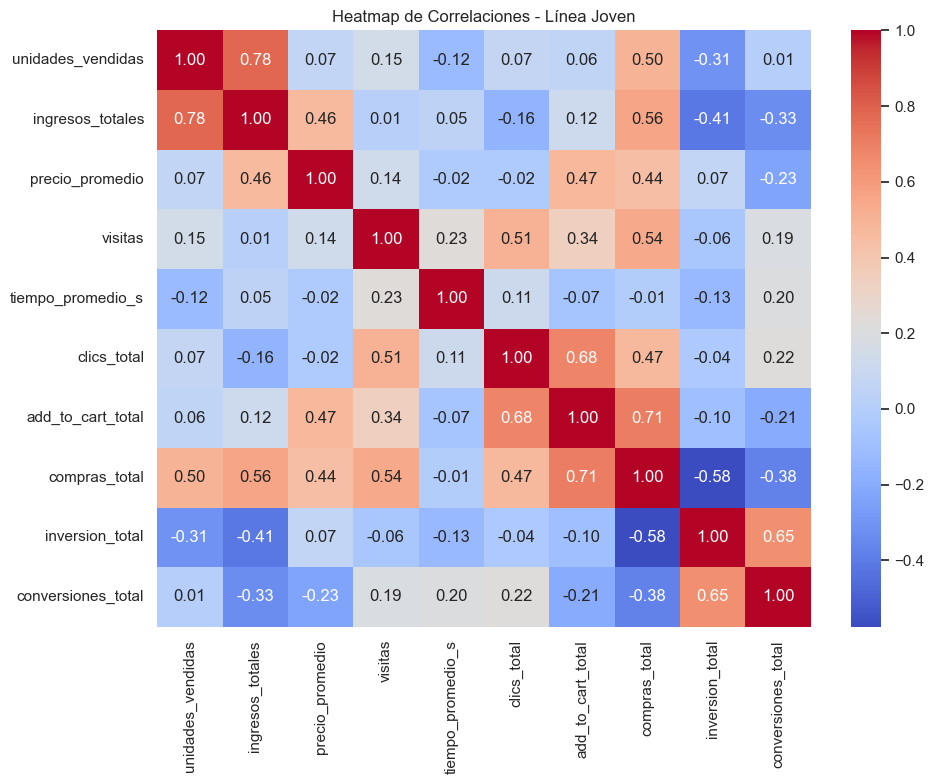


Correlaciones más relevantes (|corr| > 0.5):
unidades_vendidas ↔ ingresos_totales: 0.78
unidades_vendidas ↔ compras_total: 0.50
ingresos_totales ↔ unidades_vendidas: 0.78
ingresos_totales ↔ compras_total: 0.56
visitas ↔ clics_total: 0.51
visitas ↔ compras_total: 0.54
clics_total ↔ visitas: 0.51
clics_total ↔ add_to_cart_total: 0.68
add_to_cart_total ↔ clics_total: 0.68
add_to_cart_total ↔ compras_total: 0.71
compras_total ↔ unidades_vendidas: 0.50
compras_total ↔ ingresos_totales: 0.56
compras_total ↔ visitas: 0.54
compras_total ↔ add_to_cart_total: 0.71
compras_total ↔ inversion_total: -0.58
inversion_total ↔ compras_total: -0.58
inversion_total ↔ conversiones_total: 0.65
conversiones_total ↔ inversion_total: 0.65


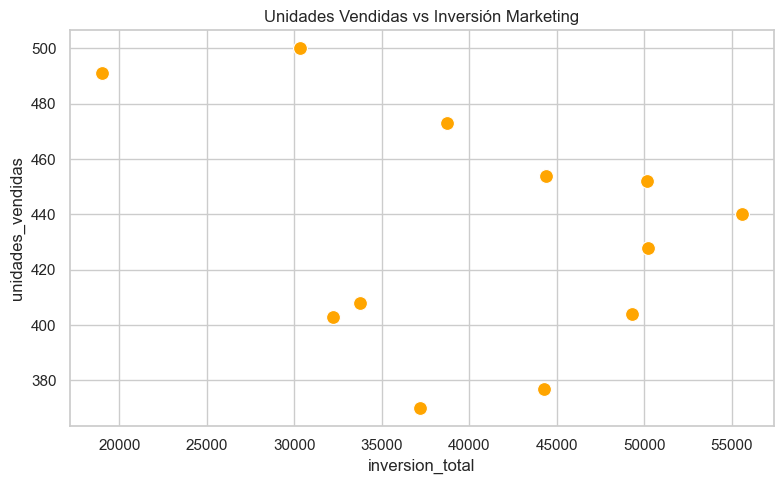

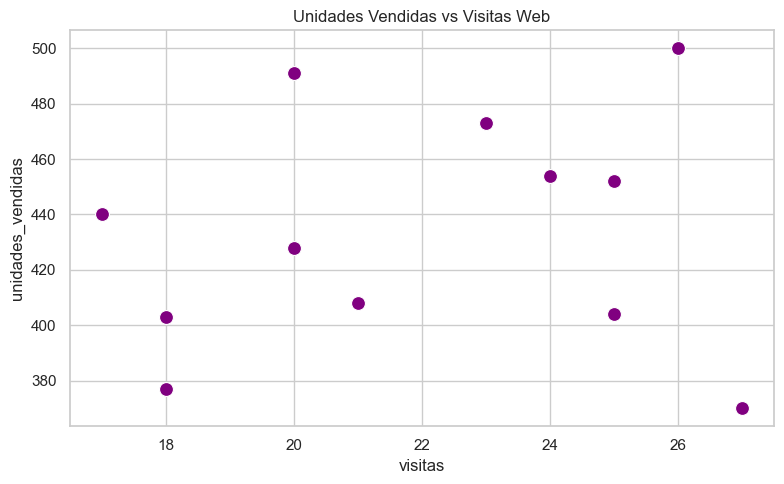

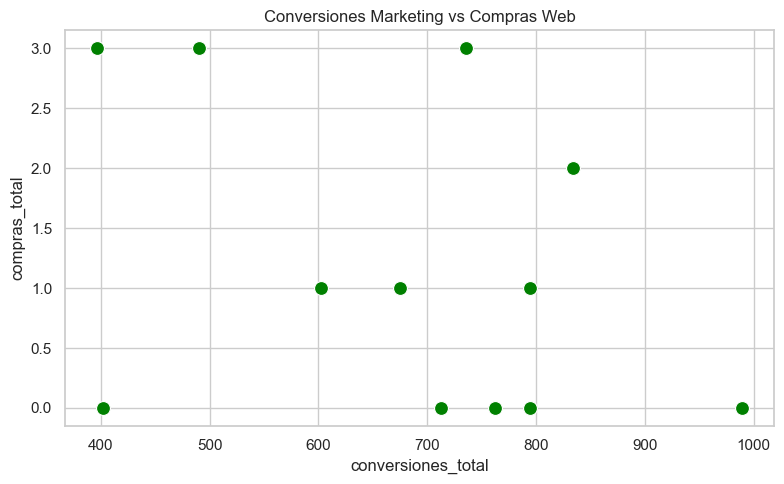


Análisis de correlaciones y scatterplots generados, mostrados y guardados en subcarpetas de modeling.


In [41]:
# --- 1. Crear DataFrame mensual combinado ---
df_combinado = ventas_mes.merge(web_mes, on='anio_mes', how='left').merge(marketing_mes, on='anio_mes', how='left')

# Mostrar primeras filas
print("Primeras filas del DataFrame combinado mensual:")
display(df_combinado.head())

# --- 2. Calcular matriz de correlaciones ---
corr_matrix = df_combinado.drop(columns='anio_mes').corr()

print("\nMatriz de correlaciones:")
display(corr_matrix)

# --- 3. Heatmap de correlaciones ---
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", ax=ax)
plt.title("Heatmap de Correlaciones - Línea Joven")
plt.tight_layout()

# Guardar figura
subdir = os.path.join(figures_dir, "correlations")
os.makedirs(subdir, exist_ok=True)
fig.savefig(os.path.join(subdir, "heatmap_correlaciones.png"))
plt.show()
plt.close(fig)

# --- 4. Mostrar correlaciones más relevantes en consola ---
# Tomaremos valores absolutos mayores a 0.5 (excepto la diagonal)
print("\nCorrelaciones más relevantes (|corr| > 0.5):")
for col1 in corr_matrix.columns:
    for col2 in corr_matrix.columns:
        if col1 != col2 and abs(corr_matrix.loc[col1,col2]) > 0.5:
            print(f"{col1} ↔ {col2}: {corr_matrix.loc[col1,col2]:.2f}")

# --- 5. Scatterplots de pares clave ---

def scatter_plot(df, x, y, color='blue', titulo="", nombre_archivo=""):
    fig = plt.figure(figsize=(8,5))
    sns.scatterplot(data=df, x=x, y=y, color=color, s=100)
    plt.title(titulo)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.tight_layout()
    
    # Guardado en subcarpeta scatter
    subdir = os.path.join(figures_dir, "scatterplots")
    os.makedirs(subdir, exist_ok=True)
    fig.savefig(os.path.join(subdir, nombre_archivo))
    plt.show()
    plt.close(fig)

# Ventas vs inversión marketing
scatter_plot(df_combinado, 'inversion_total', 'unidades_vendidas',
             color='orange',
             titulo="Unidades Vendidas vs Inversión Marketing",
             nombre_archivo="ventas_vs_inversion.png")

# Ventas vs visitas web
scatter_plot(df_combinado, 'visitas', 'unidades_vendidas',
             color='purple',
             titulo="Unidades Vendidas vs Visitas Web",
             nombre_archivo="ventas_vs_visitas.png")

# Conversiones marketing vs compras web
scatter_plot(df_combinado, 'conversiones_total', 'compras_total',
             color='green',
             titulo="Conversiones Marketing vs Compras Web",
             nombre_archivo="conversiones_vs_compras.png")

print("\nAnálisis de correlaciones y scatterplots generados, mostrados y guardados en subcarpetas de modeling.")

## 7. Modelado Predictivo - Línea Joven

Objetivo: Identificar variables que impactan más las ventas de la Línea Joven y proyectar estrategias basadas en datos.

RandomForest - RMSE: 80.30, R²: -15.27


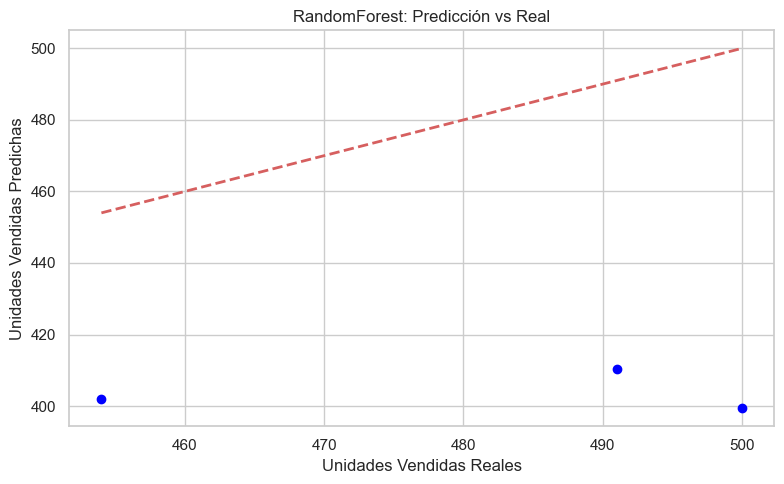


RandomForest - Importancia de Variables:


inversion_total       0.217445
conversiones_total    0.217178
tiempo_promedio_s     0.188990
clics_total           0.133971
compras_total         0.110607
add_to_cart_total     0.067449
visitas               0.064360
dtype: float64

C:\Users\alexi\AppData\Local\Temp\ipykernel_18012\2686432588.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance.values, y=importance.index, palette="viridis")


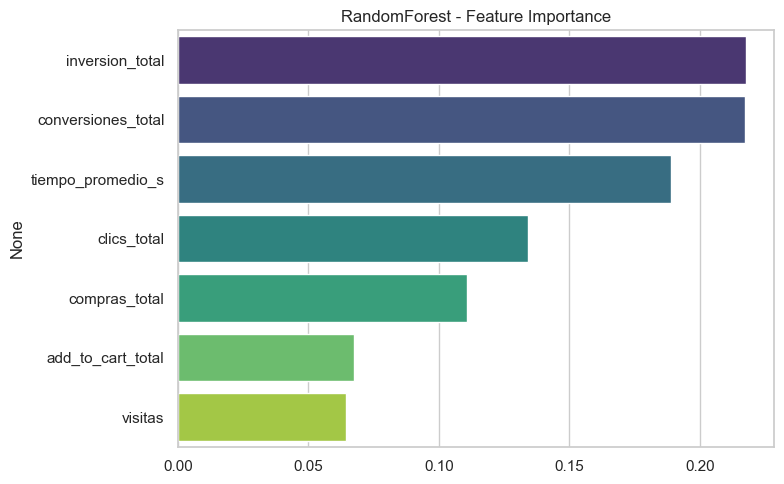

GradientBoosting - RMSE: 98.84, R²: -23.66


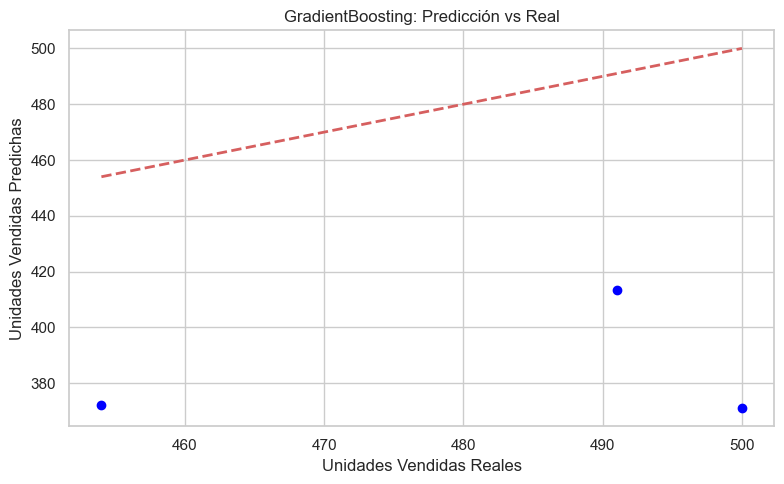


GradientBoosting - Importancia de Variables:


conversiones_total    0.554566
clics_total           0.209846
add_to_cart_total     0.111616
tiempo_promedio_s     0.051016
compras_total         0.043095
inversion_total       0.025990
visitas               0.003871
dtype: float64

C:\Users\alexi\AppData\Local\Temp\ipykernel_18012\2686432588.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance.values, y=importance.index, palette="viridis")


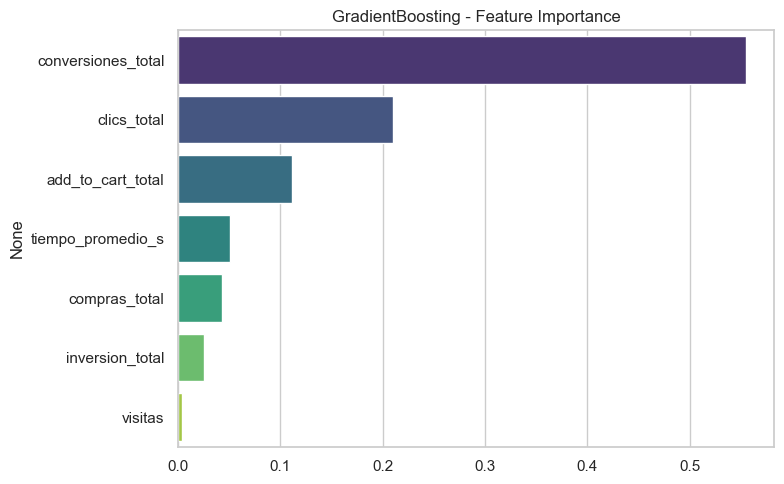

Modelado predictivo completado, gráficos de predicción y feature importance guardados en subcarpetas.


In [43]:
# Carpeta para guardar gráficos del modelado
os.makedirs(os.path.join(figures_dir, "predictions"), exist_ok=True)
os.makedirs(os.path.join(figures_dir, "feature_importance"), exist_ok=True)

# --- 1. Preparar datos para modelado ---
# Target: unidades vendidas
target = 'unidades_vendidas'

# Features: variables de web y marketing que afectan ventas
features = ['visitas','tiempo_promedio_s','clics_total','add_to_cart_total','compras_total','inversion_total','conversiones_total']

X = df_combinado[features]
y = df_combinado[target]

# --- 2. Dividir en train/test ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 3. Entrenar RandomForest y GradientBoosting ---
models = {
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    r2 = r2_score(y_test, y_pred)
    results[name] = {'model': model, 'rmse': rmse, 'r2': r2, 'y_pred': y_pred}
    
    print(f"{name} - RMSE: {rmse:.2f}, R²: {r2:.2f}")
    
    # --- 4. Gráfico Predicción vs Real ---
    fig, ax = plt.subplots(figsize=(8,5))
    ax.scatter(y_test, y_pred, color='blue')
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax.set_xlabel("Unidades Vendidas Reales")
    ax.set_ylabel("Unidades Vendidas Predichas")
    ax.set_title(f"{name}: Predicción vs Real")
    plt.tight_layout()
    fig.savefig(os.path.join(figures_dir, "predictions", f"{name}_pred_vs_real.png"))
    plt.show()
    plt.close(fig)
    
    # --- 5. Feature Importance ---
    importance = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
    print(f"\n{name} - Importancia de Variables:")
    display(importance)
    
    # Gráfico
    fig, ax = plt.subplots(figsize=(8,5))
    sns.barplot(x=importance.values, y=importance.index, palette="viridis")
    plt.title(f"{name} - Feature Importance")
    plt.tight_layout()
    fig.savefig(os.path.join(figures_dir, "feature_importance", f"{name}_feature_importance.png"))
    plt.show()
    plt.close(fig)

print("Modelado predictivo completado, gráficos de predicción y feature importance guardados en subcarpetas.")

## 8. Guardar CSV Final Combinado - Línea Joven

Guardamos el DataFrame mensual combinado para usar en el Notebook de Evaluación.

In [44]:
final_dir = "../data/final"
os.makedirs(final_dir, exist_ok=True)

csv_path = os.path.join(final_dir, "df_combinado_linea_joven.csv")
df_combinado.to_csv(csv_path, index=False)
print(f"CSV final guardado en: {csv_path}")

CSV final guardado en: ../data/final\df_combinado_linea_joven.csv


## Conclusiones globales

Podemos resumir los hallazgos clave de todo el análisis de la Línea Joven:

### A. Estadísticas descriptivas

- Ventas Línea Joven:
    - Promedio: ~15 unidades/mes
    - Precio promedio: ~1554 USD
    - Distribución amplia: desde 1 a 30 unidades por venta
- Web:
    - Tiempo promedio en página: ~90 s
    - Visitas totales y clics relativamente bajos
- Marketing:
    - Inversión promedio: 3234 USD
    - Conversión no proporcional al gasto → posible ineficiencia

### B. Análisis temporal

- Tendencia caída en ventas durante últimos 6 meses pese a un incremento de visitas web y gasto en marketing.
- Problema evidente de conversión, ya que visitas y clics aumentan, pero compras no.

### C. Correlaciones y drivers

- Correlaciones importantes:
    - `unidades_vendidas` ↔ `compras_total` (0.50)
    - `compras_total` ↔ `add_to_cart_total` (0.71)
    - `conversiones_total` ↔ `inversion_total` (0.65)

- Implicación:
    - La conversión web y el engagement (clics, add-to-cart) son los principales factores que afectan ventas.
    - La inversión de marketing no siempre se traduce en ventas → optimización necesaria.

### D. Modelado predictivo
    
- **Random Forest**: RMSE 80.3, R² negativo → modelo indica que las variables actuales no capturan completamente la dinámica de ventas, pero permite identificar drivers.
    - Variables más importantes: `inversion_total`, `conversiones_total`, `tiempo_promedio_s`, `clics_total`, `compras_total`

Gradient Boosting: RMSE 98.8, R² negativo → peor desempeño, pero resalta la relevancia de `conversiones_total`.

### Conclusión
- La caída de ventas de la Línea Joven no se debe a falta de visitas ni inversión en marketing, sino a **baja conversión** y **engagement web**.
- Las variables de web (clics, add-to-cart, tiempo en página) y marketing (conversiones) son drivers claves.
- Acciones rápidas deberían centrarse en **optimizar la conversión online** y el **retorno de marketing**.